# Risultati di Campagne di Marketing
##### Scala Matteo; matricola: 833015

Il dataset che ho scelto per il progetto riguarda una campagna di marketing condotta da una banca portoghese. Sono forniti i dati riguardo i clienti contattati, riguardo il tipo di contatto e riguardo il contesto economico/sociale al momento del contatto (più informazioni su i vari attributi sono fornite di seguito); chiaramente, oltre a ciò, è specificato se alla fine del contatto il cliente ha sottoscritto il contratto. 

---

- Fonde del dataset: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
- Creatori del dataset: Sérgio Moro, Paulo Cortez e Paulo Rita
- Paper rilevanti: https://core.ac.uk/download/pdf/55631291.pdf

In [1]:
from datetime import datetime
orario_inizio = datetime.now().time()

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sklearn import utils

np.random.seed(22)

%matplotlib inline

In [3]:
"""
aggiungo qualche funzione di utility per scaricare più agevolmente il dataset
"""
from urllib.request import urlretrieve
import os

dataset_csv = "bank-additional-full.csv"

def download_dataset_from_uci():
    from zipfile import ZipFile
    from shutil import rmtree

    archive_name = "bank-additional.zip"
    if not os.path.exists(dataset_csv) :
        urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip", archive_name)

        with ZipFile(archive_name, 'r') as zip_ref:
            zip_ref.extractall("./")

        os.rename("./bank-additional/"+dataset_csv, "./"+dataset_csv)
        os.remove(archive_name)

        for direcrory in list(os.walk("./"))[0][1]:
            rmtree(direcrory)

def download_dataset_from_bitbucket():
    if not os.path.exists(dataset_csv) :
        urlretrieve("https://bitbucket.org/byschii/progdataintensiveapplication/raw/57f53a5ffde4ffc1c81f08d93180da298597638d/bank-additional-full.csv", dataset_csv)

def download_dataset_from(source: str = "bitbucket"):
    if source == "bitbucket":
        return download_dataset_from_bitbucket()
    if source == "uci":
        return download_dataset_from_uci()
    raise Exception("le uniche due fonti online sono 'bitbucket' e 'uci', sceglierne una")


## Gli Attributi del Dataset
Come descritto sul sito dell' UCI i dati sono divisi in 4 categorie:

Dati che descrivono il cliente:
- Età: numerico intero (anni)
- Impiego: 10 categorie testuali, più "disoccupato" e "sconosciuto"
- Stato Civile: 3 categorie testuali, più "sconosciuto"
- Livello di Educazione: 7 categorie testuali, più "sconosciuto"
- Ha debiti: 2 categorie, più "sconosciuto"
- Ha mutuo sulla casa: 2 categorie testuali, più "sconosciuto"
- Ha altri prestiti: 2 categorie testuali, più "sconosciuto"

Dati sull'ultimo contatto attraverso la campagna:
- Tipo di contatti: "telefono" o "cellulare"
- Ultimo mese con contatti: 12 categorie testuali
- Ultimo giorno della settimana con contatti: 7 categorie testuali
- Durata ultimo contatto: numerico intero (secondi)

Dati aggiuntivi:
- Contatti avvenuti nell'attuale campagna: numerico intero, comprende anche l'ultimo
- Giorni passati dall'ultimo contatto in una campagna precedente: numerico intero, se è 999 il cliente non è mai stato contattato prima
- Contatti avvenuti in campagne precedenti: numerico intero
- Risultato della campagna precedente: 3 categorie testuali

Indicatori del contesto economico-sociale (al momento della campagna):
- Employment Variation Rate: numerico, calcolato su 4 mesi (dovrebbe suggerire la propensione al rischio delle persone, sulla base della differenza tra numero di persone assunete e quelle licienziate)
- Consumer Price Index: numerico, mensile (Indice dei Prezzi al Consumo, una media dei prezzi dei prodotti tipicamente acquistati di un consumatore medio)
- Consumer Confidence Index: numerico, mensile (un indice di come i consumatori percepiscono l'economia del proprio paese)
- Euro Inter Bank Offered Rate (Euribor): numerico, trimestrale (indica il tasso d'interesse medio nelle transazioni finanziarie tra banche europee)
- Number Of Employees: numerico, calcolato su 4 mesi (non avendo trovato particolari informazioni di carattere generico e osservando la tipologia di dati, assumo che si riferisca alla banca stessa e che ne suggerisca la "salute")

Per ultima c'è la variabile da predire:
- Conto deposito: "si" o "no", se alla fine della chiamata il cliente ha sottoscritto il contratto di deposito

Note:
- Riguardo lo stato civile, "divorziato" e "vedovo" coincidono
- Riguardo la durata dell'ultimo contatto: in un caso reale, prima di una chiamata non si sa quanto durerà, mentre al termine della chiamata (si sa quanto è durata, ma) si sa chiaramente il risultato che si sta cercando di predire; per questo non dovrebbe essere inclusa tra le *features* di un modello.
- Sull' Employment Variation Rate, descrizione più precisa della mia: https://www.quora.com/What-is-meant-by-employment-variation-rate-Does-it-affect-in-any-way-the-financial-decisions-that-an-individual-takes


In [4]:
# per comodità, importando i dati, cambio il nome degli attributi in qualcosa che mi sia piu familiare/espressivo
# il percorso di default è quello che si usa su kaggle per accedere ai dataset presenti su kaggle
def get_bank_marketing_data(dataset_path = "../input/progetto-data-intensive-applications/bank-additional-full.csv"):
    return pd.read_csv(
        dataset_path,
        sep = ";",
        header = 1,
        index_col=False,
        names =  [
            'age', 'job', 'civil_status', 'education', 'debts', 'housing_loan', 'other_mortgages', 
            'conctact_type', 'last_conctact_month', 'last_conctact_day', 'last_conctact_duration',
            'conctacts_current_campaign', 'days_after_last_contact', 'conctacts_past_campaign', 'past_campaign_outcome',
            'evr', 'cpi', 'cci', 'euribor', 'noe',
            'final_success'
        ]
    )

download_dataset_from('bitbucket')
bank_marketing_data = get_bank_marketing_data(dataset_csv)

Per vedere in dettaglio i valori che possono essere assunti da ogni attributo si puo usare:
```
for col in bank_marketing_data.columns:
    print("Attributo:               '" + col + "'" )
    print("Valori Assunti:         ", bank_marketing_data[col].unique())
    print("Numero Totale di Valori: ", bank_marketing_data[col].nunique())
    print('--')
```
Nota: c'è bisogno del dataset `bank_marketing_data`.

---

Come suggerito anche dalla descrizione del dataset nella pagina del sito dell'UCI, il campo che riguarda la durata dell'ultimo contatto (telefonata) si può escludere da subito.

In [5]:
last_contact_duration = bank_marketing_data['last_conctact_duration']
bank_marketing_data = bank_marketing_data.drop(axis = "columns", labels = ['last_conctact_duration'])

Prima di passare ad un analisi esplorativa del dataset, è utile convertire gli attributi da stringhe a valori numerici.

Per farlo ho deciso di usare diversi approcci:
- se l'attributo si divideva in "si" / "no" / "sconosciuto": ho assegnsato a "sconosciuto" un valore neutro (0) mentre a "vero" e "falso" due valori opposti senza particolari preferenze per il significato per il mondo reale (ad esempio, all'attributo su i mutui ho asseganto il valore 1 a "si" nonostante avere già altri mutui possa avere sia un connotato negativo nel caso un cliente non voglia aprirne altri, sia uno positivo nel caso il cliente sia abituato ad aprirne)
- alla variabile da predire ho assegnato 1 in caso di successo della campagna, -1 in caso contrario
- per quello che riguarda i mesi / giorni / livelli di educazione ho preferito associare valori che potessero corrispondere al significato della categoria originale (ad un giorno verso fine settimana corrisponde un valore piu alto, e ad un livello d'istruzione più alto corrisponde un numero maggiore)
- invece, per 'lavoro' e 'stato civile' non credo sia saggio convertire le categorie in valori numerici con un particolare senso (anche se forse i lavari potevano essere ordinati per reddito). Per questo i valori verranno codificati in "stile" *one-hot* dopo una veloce analisi dei dati che contengono.

Note:
- il sitema educativo portoghese: https://www.euroeducation.net/prof/porco.htm


In [6]:
VALORE_CLASSE = 1
bank_marketing_data['debts']                 = bank_marketing_data['debts'].map({"yes":1 , "no":-1 , "unknown": 0 })
bank_marketing_data['housing_loan']          = bank_marketing_data['housing_loan'].map({"yes":1 , "no":-1 , "unknown": 0 })
bank_marketing_data['other_mortgages']       = bank_marketing_data['other_mortgages'].map({"yes":1 , "no":-1 , "unknown": 0 })
bank_marketing_data['past_campaign_outcome'] = bank_marketing_data['past_campaign_outcome'].map({"success":1, "failure":-1, "nonexistent": 0 })
bank_marketing_data['conctact_type']         = bank_marketing_data['conctact_type'].map({"telephone":1, "cellular": -1 }) # piccola eccezione
#---
bank_marketing_data['final_success']         = bank_marketing_data['final_success'].map({"yes":VALORE_CLASSE, "no":-VALORE_CLASSE})
#---
# manca la "conversione" per alcuni mesi e alcuni giorni, perché non sono presenti nel dataset
bank_marketing_data['last_conctact_month']   = bank_marketing_data['last_conctact_month'].map({'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
bank_marketing_data['last_conctact_day']     = bank_marketing_data['last_conctact_day'].map({'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
education_converter = {
    'unknown':             np.nan,
    'university.degree':   6,
    'professional.course': 5,
    'high.school':         4,
    'basic.9y':            3,
    'basic.6y':            2,
    'basic.4y':            1,
    'illiterate':          0
}
bank_marketing_data['education']             = bank_marketing_data['education'].map(education_converter)

A questo punto tutti gli attributi (tranne 2 ancora da elaborare) siano di tipo numerico; con 'education' che contiene anche valori nulli. 

In [7]:
print(bank_marketing_data.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41187 entries, 0 to 41186
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         41187 non-null  int64  
 1   job                         41187 non-null  object 
 2   civil_status                41187 non-null  object 
 3   education                   39456 non-null  float64
 4   debts                       41187 non-null  int64  
 5   housing_loan                41187 non-null  int64  
 6   other_mortgages             41187 non-null  int64  
 7   conctact_type               41187 non-null  int64  
 8   last_conctact_month         41187 non-null  int64  
 9   last_conctact_day           41187 non-null  int64  
 10  conctacts_current_campaign  41187 non-null  int64  
 11  days_after_last_contact     41187 non-null  int64  
 12  conctacts_past_campaign     41187 non-null  int64  
 13  past_campaign_outcome       411

## Analisi Esplorativa dei Clienti
Si può notare che i clienti contattati dalla banca per questa campagna sono particolarmente concecntrati nella fascia 30 - 50 anni

Il più giovane: 17anni
Il più anziano: 98anni


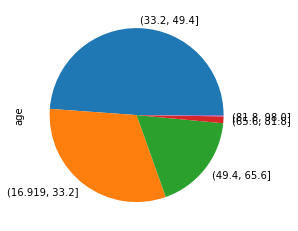

In [8]:
pd.cut(bank_marketing_data["age"], 5).value_counts().plot.pie();
print("Il più giovane: "+ str(bank_marketing_data["age"].min()) + "anni")
print("Il più anziano: " + str(bank_marketing_data["age"].max()) + "anni")

Nel caso degli ultimi tre attributi relativi al cliente (debiti, mutuo sulla casa, altri prestiti) i valori sono distribuiti uniformemente solo nel caso del 'mutuo sulla casa'. Negli altri due attributi, i valori sono spostati verso il -1 (ovvero, verso l'assenza di altri mutui o debiti).  

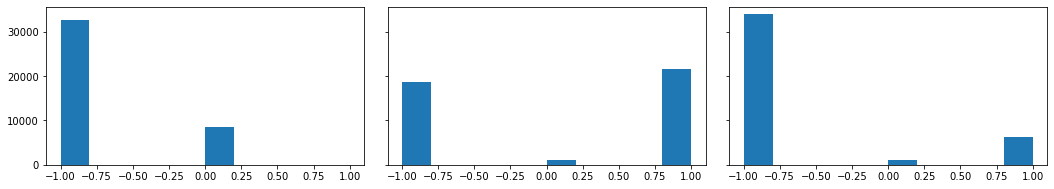

In [9]:
fig, axs = plt.subplots(1, 3, sharey = 'row', figsize=(15,3))

axs[0].hist(  bank_marketing_data["debts"]            )
axs[1].hist(  bank_marketing_data["housing_loan"]     )
axs[2].hist(  bank_marketing_data["other_mortgages"]  )

fig.tight_layout(pad = 2)

La distrubuzione dei lavori appare sblilanciata 

Distribuzione dei lavori


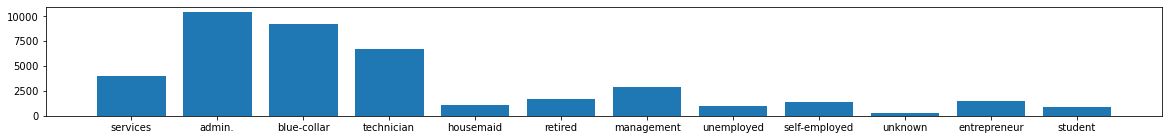

In [10]:
b = list(bank_marketing_data['job'].unique())
v = [
    len(bank_marketing_data[bank_marketing_data['job'] == j])
    for j in b
]
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.bar(b,v)

print("Distribuzione dei lavori")

### Gestione dei valori nulli nell'educazione

Per stabilire se fossero trascurabili tutte quelle istanze dove il livello di istruzione è sconosciuto ho decisto di dividere l dataset il due parti distinte, una parte con tutte le istanze dove è nota l'educazione e una parte dove l'educazione è ignota, per entrambe le parti ho calcolato alcune statistiche descrittive con `.describe`, alla fine ho calcolato la differenza tra le varie statistiche delle due parti. 

Osservando il risultato non risulta essere elevato il divario tra le due parti del dataset. Gli unici casi in cui le medie di distanziano particolarmente è per gli attributi dell'età, dei giorni dall'ultimo contatto e del noe, che sono tutti attributi con un dominio di valori più ampio rispetto agli altri ed in ogni caso la differrenza tra i percentili rimane bassa.

In [11]:
cols = list(bank_marketing_data.columns)
cols.remove('education')

data_education_unknown = bank_marketing_data[  bank_marketing_data['education'].isnull() ][ cols ].describe()
data_education_known   = bank_marketing_data[ ~bank_marketing_data['education'].isnull() ][ cols ].describe()

data_education_unknown - data_education_known

age         debts  housing_loan  other_mortgages  \
count -37725.000000 -37725.000000 -37725.000000    -37725.000000   
mean       3.609241      0.112429     -0.039314        -0.025803   
std        2.193891      0.062003      0.002906        -0.023910   
min        0.000000      0.000000      0.000000         0.000000   
25%        3.000000      0.000000      0.000000         0.000000   
50%        5.000000      0.000000      0.000000         0.000000   
75%        5.000000      1.000000      0.000000         0.000000   
max       -6.000000     -1.000000      0.000000         0.000000   

       conctact_type  last_conctact_month  last_conctact_day  \
count  -37725.000000        -37725.000000      -37725.000000   
mean        0.098629            -0.135887           0.076744   
std         0.023010            -0.105024           0.037321   
min         0.000000             0.000000           0.000000   
25%         0.000000             0.000000           0.000000   
50%         0.000000             0.000000           0.000000   
75%         0.000000            -1.000000           0.000000   
max         0.000000             0.000000           0.000000   

       conctacts_current_campaign  days_after_last_contact  \
count               -37725.000000            -37725.000000   
mean                     0.029809               -20.505641   
std                     -0.050077                44.571467   
min                      0.000000                 1.000000   
25%                      0.000000                 0.000000   
50%                      0.000000                 0.000000   
75%                      0.000000                 0.000000   
max                    -27.000000                 0.000000   

       conctacts_past_campaign  past_campaign_outcome           evr  \
count            -37725.000000          -37725.000000 -37725.000000   
mean                  0.055838               0.012663     -0.023761   
std                   0.135470               0.029195      0.083211   
min                   0.000000               0.000000      0.000000   
25%                   0.000000               0.000000      0.000000   
50%                   0.000000               0.000000      0.000000   
75%                   0.000000               0.000000      0.000000   
max                  -1.000000               0.000000      0.000000   

                cpi           cci       euribor           noe  final_success  
count -37725.000000 -37725.000000 -37725.000000 -37725.000000   -37725.00000  
mean       0.086600      0.652298     -0.052364     -7.814235        0.06753  
std        0.031155      0.071437      0.083230      9.632086        0.07555  
min        0.000000      0.000000      0.001000      0.000000        0.00000  
25%        0.125000      0.000000     -0.017000      0.000000        0.00000  
50%        0.474000      0.000000      0.000000      0.000000        0.00000  
75%        0.000000      0.000000      0.000000      0.000000        0.00000  
max        0.000000      0.000000      0.000000      0.000000        0.00000

Inoltre, le persone di cui non è nota l'educazione sono solo una **piccola percentuale**.

4%


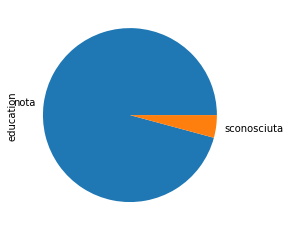

In [12]:
bank_marketing_data["education"].isnull().value_counts().plot.pie(labels = ["nota", "sconosciuta"])

nulli = bank_marketing_data["education"].value_counts(dropna = False)[np.nan]
tutti = bank_marketing_data["education"].value_counts(dropna = False).sum() # len(bank_marketing_data)
print( str(int(nulli / tutti * 100)) + "%" )

Quindi, per le ragioni sopra descritte, mi sento tranquillo nel elimiare i dati mancanti (che ricordo sono presenti solo nell'attriburo dell'educazione).

In [13]:
bank_marketing_data.dropna(inplace = True)

Ora, prima di passare alla codifica *one-hot* delle ultime classi, controllo la variabilità dei vari attributi e la loro correlazione.

**Importante:** la variabile da predire è fortemente sbilanciata verso i mancati successi. Nonostante si possa pensare che ciò semplicemente rifletta una naturale caratteristica del contesto, tipo la propensione dei clienti a rifiutare offerte dalla banca, è buona norma bilanciare gli esempi (magari togliendo principalmente esempi dove non sono noti (= 999) i giorni passati dall'ultimo contatto, siccome anche quell'attributo è molto sbilanciato).

In [14]:
print('valore assunto |', 'percentuale presenza | ', 'attributo relativo')
for c in bank_marketing_data.columns:
    v = (bank_marketing_data[c]).value_counts(normalize = True)
    if v.max() > 0.85:
        print( v.index[v.argmax()], "\t\t", round(v.max()*100, 2), "\t\t\t", c )

valore assunto | percentuale presenza |  attributo relativo
999 		 96.41 			 days_after_last_contact
0 		 86.43 			 conctacts_past_campaign
0 		 86.43 			 past_campaign_outcome
-1 		 88.88 			 final_success


Si può anche notare che, i giorni passati dall'ultimo contatto sono stati registrati solo per il 4% dei clienti; l'informazone è poco variabile e potrebbe essere quasi inutile. Inoltre, di alcune delle persone si conosce il risultato della campagna precedente anche se non sono mai state contattate (altrimenti le percentuali sarebbero identiche) questo dovrebbe suggerire che il dato è inaffidabile. Data la scarsa variabilità e l'incoerenza del dato ho deciso di rimuoverlo.


Per vedere i dati "incoerenti":
```
len(
    bank_marketing_data[
        (bank_marketing_data.days_after_last_contact == 999) & (bank_marketing_data.past_campaign_outcome == -1)
    ]
)
```

In [15]:
bank_marketing_data.drop(columns=["days_after_last_contact"], inplace = True)

Correlazioni particolari tra i dati si possono vedere soprattutto tra i dati che descrivono l'andamento dell'economia (il "quadrattino rosso" nell ancolo in basso).

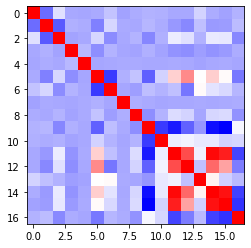

In [16]:
plt.imshow(bank_marketing_data.corr(), cmap='bwr') # blu > inversamente, rosso > proporzionali

In [17]:
"""
per gestire le correlazioni ho scritto una piccola funzione che moltiplica tra loro gli attributi correlati, come suggerito a lezione
"""
def remove_correlations(dataset, to_join:list):
    for joinset in to_join:
        new_dataset_column_name = "_".join(joinset)

        data = dataset[joinset[0]].values
        for j in joinset[1:]:
            data = data * dataset[j].values
        
        dataset.insert(
            len(dataset.columns),
            new_dataset_column_name,
            data
        )
        
    return dataset

bank_marketing_data = remove_correlations(
    bank_marketing_data,
    [
        ['conctacts_past_campaign', 'past_campaign_outcome'],
        ['cpi', 'euribor', 'noe'] 
    ]
)


## One Hot Encoding e Bilanciamento
Dopo aver analizzato i dati, passo a ribilanciare gli esempi e a codificare gli attributi dello *stato civie* e del *lavoro*.

In [18]:
# la definisco per usarla in seguito
def print_bilanciamento(y_pos, y_neg):
    print("Bilanciamento:", round(y_neg/(y_neg+y_pos),3)*100, round(y_pos/(y_neg+y_pos),3)*100 )
    print("---")

In [19]:
final_success_counts = bank_marketing_data['final_success'].value_counts()
excess =  final_success_counts[-VALORE_CLASSE] - final_success_counts[VALORE_CLASSE] # quanti "risultati negativi" sarebbero da cavare
total = len(bank_marketing_data['final_success'])
print('Esempi negativi in eccesso:', str(excess) + " (circa il " + str(round(excess/total, 4)*100)+ "%).", "Su un totale di:", total)

N_ESEMPI_DA_ELIMINARE = excess #// 1000 * 1000

Esempi negativi in eccesso: 30678 (circa il 77.75%). Su un totale di: 39456


Prima di ribilanciare il dataset converto le classi che sono ancora testuali in binarie, con un nuovo attributo per ogni possibile istanza della classe.

In [20]:
# notare che se questo blocco segue quello dove viene bilanciato il dataset
# il bilanciamento impiega molto piu tempo (forse perche copiare stringhe è 
# particolarmente "costoso")
bank_marketing_data = pd.concat(
    [
        bank_marketing_data,
        pd.get_dummies(bank_marketing_data['civil_status'], prefix='civil_status').replace(0, -1, inplace = False)
    ], axis = 1
).drop(['civil_status'], axis=1, inplace = False)

bank_marketing_data = pd.concat(
    [
        bank_marketing_data,
        pd.get_dummies(bank_marketing_data['job'], prefix='job').replace(0, -1, inplace = False)
    ], axis = 1
).drop(['job'], axis=1, inplace = False)

##### Il bilanciamento
L'ho fatto in maniera tale che venissero elimiate istanze con attributi che erano particolarmente sovrarappresentati nel dataset

In [21]:

# faccio un filtro che selezioni esempi con istanze di attributi sbilanciate
to_be_excluded = (bank_marketing_data['final_success'] == -VALORE_CLASSE) & (bank_marketing_data['past_campaign_outcome'] == 0) & (bank_marketing_data['conctacts_past_campaign'] == 0)
# creo una copia solo con le colonne
bank_marketing_data_balanced = pd.DataFrame(columns = bank_marketing_data.columns)
excluded = 0

# a dir la verità non conosco nessuna maniera elegante di filtrare esattamente
# un certo numero di esempi, quindi userò un lunghissimo e lentissimo for
for i in range(len(bank_marketing_data)):
    if to_be_excluded.iloc[i]:
        excluded += 1
    else:
        bank_marketing_data_balanced = bank_marketing_data_balanced.append(
            # si potrebbe lavorare per mettere piu righe alla volta ed essere piu veloci, ma tant'è
            bank_marketing_data.iloc[i], ignore_index = True
        )
    
    # finche non raggiungo il num minimo di istanze che voglio eliminare
    if excluded == N_ESEMPI_DA_ELIMINARE: break
    
# dopo aver filtrato gli #N_ESEMPI_DA_ELIMINARE negativi di cui sopra, i restanti li metto dentro tutti
bank_marketing_data_balanced = bank_marketing_data_balanced.append(bank_marketing_data.iloc[i:], ignore_index = True )
assert bank_marketing_data_balanced[ bank_marketing_data_balanced['final_success'] == VALORE_CLASSE].shape, bank_marketing_data[ bank_marketing_data['final_success'] == VALORE_CLASSE].shape

print_bilanciamento(
    np.sum(bank_marketing_data_balanced['final_success']==VALORE_CLASSE),
    np.sum(bank_marketing_data_balanced['final_success']==-VALORE_CLASSE)
)

Bilanciamento: 50.0 50.0
---


## Addestramento dei Modelli

Ora che il dataset è pronto, non rimane che dividerlo in parte di trainig e parte di test e addestrare alcuni modelli di classificazione.

**Importante:** I modelli sono un po'lenti da addestrare, per questo ho lasciato la possibilità di limitare la grandezza del dataset. Attenzione: perché abbassare la quantità di dati fa risparmiare tempo ma fa anche apparire il modello molto accurato; dall'altra parte lasciare molti dati migliora il modello sottoponendolo ad istanze più difficili ma rallenta molto l'addestramento. Addestrando su 8mila istanze si impiegano circa 10min.

In [22]:
def split_features_target(marketing_data, instances_limit:int = 8000, target:str = 'final_success'):
    if len(marketing_data) > instances_limit:
        # mescolo sempre un po
        marketing_data = marketing_data[ : instances_limit]

        # separo x e y
        target_column = [target]
        features = list(marketing_data.columns)
        features.remove( target )

        X = marketing_data[ features ]
        y = marketing_data[ target_column ]

        return X,y
    else:
        raise Exception('Diminuire il limite di istanze: al massimo '+str( len(marketing_data) ))

Separo i dati e preparo la cross-validation statificata.

In [23]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron, LogisticRegression

X,y = split_features_target(bank_marketing_data_balanced) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, shuffle = True)
skf = StratifiedKFold(3, shuffle=True)

Provo a vedere che risultati si ottengono con un semplice _Perceptron_ (non un gran successo).

In [24]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.pipeline import Pipeline

import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings("ignore", category = DataConversionWarning)
warnings.filterwarnings("ignore", category = ConvergenceWarning)

model_prec = Perceptron()
model_prec.fit(X_train, y_train)
print(model_prec.score(X_test, y_test))

0.49981252343457067


Poi utilizzo modelli più complessi, esplorando diverse combinazioni di iperparametri utilizzando la *grid search*. 

---

Il primo è una *regressione logistica* preceduta solo da *Standardizzazzione* / *Equiparazione della scala* delle features.

Come si può notare dai risulati (rispetto alla soluzione precedente) si possono guadagnare 30 punti percentuali di accuratezza. 

In [25]:
p = Pipeline([
    ("preproc1", None),
    ("regressor", LogisticRegression(
        solver="saga",
        max_iter = 1400,
        )
    )
])

grid =[
    {   
        "preproc1": [MinMaxScaler(), StandardScaler()],
        "regressor__penalty": [None],
    },
    {
        "preproc1": [MinMaxScaler()],
        "regressor__penalty": ["elasticnet"],
        "regressor__C": [0.01, 0.1, 1, 10],  
        "regressor__l1_ratio":[0.1, 0.3, 0.5, 0.7, 0.9]
    }
]# > 8 prove

gs_simplelogreg = GridSearchCV(p, grid, cv=skf, n_jobs = 4, verbose = 9)
gs_simplelogreg.fit(X_train, y_train)

pd.DataFrame(gs_simplelogreg.cv_results_).sort_values("rank_test_score").drop(columns = ['mean_fit_time','std_fit_time','mean_score_time', 'std_score_time']).head(3)

Fitting 3 folds for each of 22 candidates, totalling 66 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  66 out of  66 | elapsed:   14.9s finished


param_preproc1 param_regressor__penalty param_regressor__C  \
3  MinMaxScaler()               elasticnet               0.01   
4  MinMaxScaler()               elasticnet               0.01   
5  MinMaxScaler()               elasticnet               0.01   

  param_regressor__l1_ratio  \
3                       0.3   
4                       0.5   
5                       0.7   

                                              params  split0_test_score  \
3  {'preproc1': MinMaxScaler(), 'regressor__C': 0...           0.862767   
4  {'preproc1': MinMaxScaler(), 'regressor__C': 0...           0.862767   
5  {'preproc1': MinMaxScaler(), 'regressor__C': 0...           0.862767   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
3           0.851519           0.858188         0.857491        0.004619   
4           0.851519           0.858188         0.857491        0.004619   
5           0.851519           0.858188         0.857491        0.004619   

   rank_test_score  
3                1  
4                1  
5                1

Cerco ulteriori miglioramenti aggiungendo features polinomiali prima della regressione.

In [26]:
p = Pipeline([
    ("preproc1", MinMaxScaler()),
    ("preproc2", PolynomialFeatures(degree=2)),
    ("regressor", LogisticRegression(
        solver="saga",
        max_iter = 1400,
        penalty = "elasticnet"
        )
    )
])

grid =[
    {
        "regressor__C": [0.1, 1, 10], 
        "regressor__l1_ratio":[0.25, 0.75, 0.9] 
    }
]# > 8 prove

gs_logreg = GridSearchCV(p, grid, cv=skf, n_jobs = 4, verbose = 9)
gs_logreg.fit(X_train, y_train)

pd.DataFrame(gs_logreg.cv_results_).sort_values("rank_test_score").drop(columns = ['mean_fit_time','std_fit_time','mean_score_time', 'std_score_time']).head(3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done  24 out of  27 | elapsed:  5.2min remaining:   39.1s
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  6.3min finished


param_regressor__C param_regressor__l1_ratio  \
5                  1                       0.9   
4                  1                      0.75   
3                  1                      0.25   

                                             params  split0_test_score  \
5   {'regressor__C': 1, 'regressor__l1_ratio': 0.9}           0.859393   
4  {'regressor__C': 1, 'regressor__l1_ratio': 0.75}           0.861080   
3  {'regressor__C': 1, 'regressor__l1_ratio': 0.25}           0.854893   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
5           0.871204           0.861564         0.864054        0.005133   
4           0.868391           0.862127         0.863866        0.003228   
3           0.862205           0.865504         0.860867        0.004434   

   rank_test_score  
5                1  
4                2  
3                3

Infine, utilizzo anche un *Support Vector Classifier*

In [27]:
from sklearn.svm import SVC

model = Pipeline([
    ("preproc1", None),
    ("preproc2", PolynomialFeatures(degree = 2)),
    ("regressor", SVC()),
])

grid =[
    {
        # prove con kernel diverso da polinomiale
        "preproc1": [MinMaxScaler()],
        "regressor__C": [1, 10],
        "regressor__kernel" : ["rbf", "sigmoid"]
    },
    {
        "preproc1": [MinMaxScaler(), StandardScaler()],
        "preproc2": [None],
        "regressor__kernel": ['poly'],
        "regressor__degree": [1, 2, 3, 4], # [0] => kernel lineare 
        "regressor__C": [0.1, 1, 10]        
    }
]

gs_svm = GridSearchCV(model, grid, cv=skf, n_jobs = 4, verbose = 8)
gs_svm.fit(X_train, y_train)
pd.DataFrame(gs_svm.cv_results_).sort_values("rank_test_score").drop(columns = ['mean_fit_time','std_fit_time','mean_score_time', 'std_score_time']).head(3)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:   53.0s finished


param_preproc1 param_regressor__C param_regressor__kernel param_preproc2  \
13  MinMaxScaler()                 10                    poly           None   
10  MinMaxScaler()                  1                    poly           None   
7   MinMaxScaler()                0.1                    poly           None   

   param_regressor__degree                                             params  \
13                       2  {'preproc1': MinMaxScaler(), 'preproc2': None,...   
10                       3  {'preproc1': MinMaxScaler(), 'preproc2': None,...   
7                        4  {'preproc1': MinMaxScaler(), 'preproc2': None,...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
13           0.860517           0.868391           0.881823         0.870244   
10           0.861080           0.867267           0.881823         0.870057   
7            0.859393           0.863892           0.880135         0.867807   

    std_test_score  rank_test_score  
13        0.008796                1  
10        0.008695                2  
7         0.008909                3

Durante alcune prove ho esplorato l'utilizzo anche di Keras, ma non ho ottenuto risultati soddisfacenti (80% di accuratezza, circa come *sklearn*, ma con più tempo investito, per questo ho deciso di non riportarlo interamente in una cella interattiva ma solo una bozza testuale).

```
features      = X.shape[1]
y_categorical = list(map(lambda yi : [0,1] if yi == -1 else [1,0] , y))

input_layer   = Input(features)
dense_layer   = Dense(features // 2)(input_layer)
dropuot_layer = Dropout(0.4)(dense_layer)
dense_layer   = Dense(features // 5)(dropuot_layer)
output_layer  = Dense(2, activation = 'softmax')(dense_layer)

model         = Model(input_layer, output_layer)
optimizer     = "adam"
loss          = "categorical_crossentropy"
```

---

Sempre per testare molte opzioni, provo a creare il modello senza usufruire di alcuna conoscenza dei dati (trasformerò tutte le categorie in 1/0 e non bilancerò). È per lo più dimostrativo e pieno di _bad-practices_.

In [28]:
#######################################################
# Ho scritto due righe per poter bilanciare il datest #
# creando istanze sintetiche con 'imblearn'           #
#######################################################
balance_train = False
balance_test = False
if balance_train or balance_test:
    from imblearn.over_sampling import SMOTE, SVMSMOTE
    smote = SVMSMOTE()

    
# reimporto tutto il dataset
bank_marketing_data = get_bank_marketing_data(dataset_csv)

# escludo l'obiettivo
columns = list(bank_marketing_data.columns)
columns.remove('final_success')

# converto tutte le colonne
for c in columns:
    if bank_marketing_data[c].dtype == "object": # di tipo 'obj' che è stringa
        bank_marketing_data = pd.concat(
            [
                bank_marketing_data,
                pd.get_dummies(bank_marketing_data[c], prefix=c) # usando la funzione 'get_dummies'
            ], axis = 1
        ).drop([c], axis=1, inplace = False)

# la classe da predirre la converto come sopra
target_class = bank_marketing_data['final_success'].map({"yes":VALORE_CLASSE, "no":-VALORE_CLASSE})
bank_marketing_data.drop(['final_success'], axis=1, inplace = True)

# preparo i dati
X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(
    bank_marketing_data, target_class,
    shuffle = True,
    test_size=1/2  # non ho messo il sito terzo per abbreviare i tempi
)

# nel caso si voglia provare a bilanciare
if balance_train:
    print('balance_train before ->', len(y_train_naive), '=', np.sum(y_train_naive == 1), '+', np.sum(y_train_naive == -1))
    X_train_naive, y_train_naive = smote.fit_resample(X_train_naive, y_train_naive)
    print('balance_train after ->', len(y_train_naive), '=', np.sum(y_train_naive == 1), '+', np.sum(y_train_naive == -1))

if balance_test:
    print('balance_test before ->', len(y_test_naive), '=', np.sum(y_test_naive == 1), '+', np.sum(y_test_naive == -1))
    X_test_naive, y_test_naive = smote.fit_resample(X_test_naive, y_test_naive)
    print('balance_test after ->', len(y_test_naive), '=', np.sum(y_test_naive == 1), '+', np.sum(y_test_naive == -1))

gs_naive = GridSearchCV(
    Pipeline([
        ("preproc1", StandardScaler()),
        ("suvecl", SVC()),
    ]),[
        {
            "suvecl__C": [0.1, 1, 10],
        },
        {
            "suvecl__kernel": ['poly'],
            "suvecl__degree": [2, 3]
        }
    ], cv=skf, n_jobs = 2, verbose = 9)

gs_naive.fit(X_train_naive, y_train_naive)

pd.DataFrame(gs_naive.cv_results_).sort_values("rank_test_score").drop(columns = ['mean_fit_time','std_fit_time','mean_score_time', 'std_score_time']).head(3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   23.7s
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.1min finished


param_suvecl__C param_suvecl__degree param_suvecl__kernel  \
1               1                  NaN                  NaN   
3             NaN                    2                 poly   
2              10                  NaN                  NaN   

                                            params  split0_test_score  \
1                                 {'suvecl__C': 1}           0.905317   
3  {'suvecl__degree': 2, 'suvecl__kernel': 'poly'}           0.899345   
2                                {'suvecl__C': 10}           0.899782   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
1           0.906323           0.906469         0.906036        0.000512   
3           0.902244           0.900787         0.900792        0.001184   
2           0.900787           0.901078         0.900549        0.000555   

   rank_test_score  
1                1  
3                2  
2                3

Si può notare che il modello raggiunge un accuratezza superiore al 90%, ma bisogna ricordare che è stato addestrato sul dataset non bilanciato dove più di un quarto dei risultati finali sono "negativi".

## Analisi e Valutazione dei Modelli

Per comodità: 
- raggruppo i modelli addestrati e di dati su cui valutarli in due dizionari
- preparo una funzione che restituisce la _confusion matrix_ come un DataFrame
- scrivo una funzione che calcoli le metriche più utili (accuracy,precision,recall,f1-score) ultilizzando la _confusion matrix_
- creo una funzione che sia una scorciatoria per la funzione sopra descritta

In [29]:
from sklearn.metrics import confusion_matrix

# dizionari
models = {
    "naive": gs_naive.best_estimator_, 
    "svm": gs_svm.best_estimator_,
    "logreg": gs_logreg.best_estimator_,
    "simplelogreg": gs_simplelogreg.best_estimator_
}

data = {
    "naive": (X_test_naive, y_test_naive), 
    "svm": (X_test, y_test),
    "logreg": (X_test, y_test),
    "simplelogreg": (X_test, y_test)
}


def get_confusion_matrix(model, Xy_test, m_type = None) -> pd.DataFrame :
    """
    calcola la confusio matrix a partire dal modello e dai dati di test
    
    può essere usata in due maniere:
        - passando un modello (dal primo dizionario) e una tupla (dal secondo dizionario)
        - passando tutto il primo dizionario, tutto il secondo dizionario e una chiave per estrarre modello e dati dai dizionari
    """
    if m_type:
        model = model[m_type]
        X_test, y_test = Xy_test[m_type]
    else:
        X_test, y_test = Xy_test
    
    return pd.DataFrame(
        confusion_matrix(y_test, model.predict(X_test)),
        index = model.classes_,
        columns = model.classes_
    )

def get_scores_from_confusion_matrix(confusion_matrix: pd.DataFrame, avg:bool = False):
    """
    potevo importare 'precision_score, recall_score, accuracy_score, f1_score'
    ma era troppo lento, con questa funzione risparmio 1/6 del tempo
    """
    # [predetta] [reale]
    true_negative = confusion_matrix[-1][-1] # caught_negatives
    false_negative = confusion_matrix[-1][1] # missed_positives
    false_positive = confusion_matrix[1][-1] # missed_negatives
    true_positive = confusion_matrix[1][1]   # caught_positives
    
    # rapporto tra quelli che ho beccato e quelli che mi sono sbagliato a trovare
    precision_pos = true_positive / (true_positive + false_positive) 
    precision_neg = true_negative / (true_negative + false_negative)
    
    # rapporto tra quelli che ho beccato e quelli che avrei potuto trovare
    recall_pos = true_positive / (true_positive + false_negative) # caught_pos / (caught_pos + missed_pos )
    recall_neg = true_negative / (true_negative + false_positive) # caught_neg / (caught_neg + missed_neg )
    
    f1_pos = (precision_pos * 2 * recall_pos) / (recall_pos + precision_pos)
    f1_neg = (precision_neg * 2 * recall_neg) / (recall_neg + precision_neg)
    
    if avg: 
        return {
            "accuracy":  (true_positive + true_negative)/(true_positive + false_positive + true_negative + false_negative),
            "precision": (precision_pos+precision_neg)/2,
            "recall":    (recall_pos+recall_neg)/2,
            "f1":        (f1_pos+f1_neg)/2
        }
    else:
        return {
            "accuracy":  (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative),
            "precision": (precision_pos,  precision_neg),            
            "recall":    (recall_pos,     recall_neg),
            "f1":        (f1_pos,         f1_neg)
        }

def get_scores(model, Xy_test, m_type = None, avg = False):
    cm = get_confusion_matrix(model, Xy_test, m_type )
    return get_scores_from_confusion_matrix(cm, avg)

Analizzo prima il modello addestrato su i dati "non trattati". Stampo le metriche e le discuto.

In [30]:
confusion_mx = get_confusion_matrix( models, data, 'naive')
confusion_mx

-1    1
-1  17776  458
 1   1448  912

In [31]:
get_scores_from_confusion_matrix(confusion_mx)

{'accuracy': 0.9074487714868408,
 'precision': (0.6656934306569343, 0.9246774864752393),
 'recall': (0.3864406779661017, 0.974882088406274),
 'f1': (0.48900804289544236, 0.9491163436382081)}

Come si può notare dalle metriche, il modello risulta molto accurato, ma questo è dato dal fatto che il modello durante l'addestramento ha trovato molti più esempi di istanze negative che quindi erano sovrarappresentate ("apparivano" con un peso maggiore) nel calcolo dell'errore e di conseguenza anche nel calcolo del gradiente, che ha portato ad un minimo "sbagliato" e provocato alla fine gli scarsi risultati estrapolati dalle metriche.

Lo sbilanciamento delle classi causa anche lo sbilanciamento dei risultati su _precision_ e _recall_. Il modello è "bravo" a classificare istanze negative, perché essendo statato sovraesposto durante l'addestrametno a questo tipo di istanze, da per scontato che sia tutto appartenente alla classe negativa, alzando il numero di falsi negativi e peggiorando _precision_ e _recall_ sulla classe positiva. 

Segue anche il codice per vedere come il dataset è realmente distribuito e come il modello pensa che sia distribuito:
```
print('Reale separazione')
print_bilanciamento(np.sum(confusion_mx[confusion_mx.index == 1].values), np.sum(confusion_mx[confusion_mx.index == -1].values))
print('Secondo il modello:')
print_bilanciamento(sum(confusion_mx[1]), sum(confusion_mx[-1]))
```


Bilanciando SOLO i dati di test (aumentando i casi positivi) mi aspetto che i problemi vengano amplificati:
- i veri negativi rimarranno pressoché invariati
- le nuove istanze "facili" finiscono nei veri positivi
- molti positivi aggiunti vengono classificati come negativi (appunto perché l'iperpiano trovato è biased)
- nessun miglioramento memmeno nei falsi positivi

Ho fatto qualche prova bilanciando sia la parte di train che quela di test (circa 70mila istanze, molto lento): le varie metriche del modello risultano molto migliori, ma probabilmente (se non ho capito male [come funziona SMOTE](https://rikunert.com/SMOTE_explained)) ciò è dato dal fatto che il calcolo delle metriche viene fatto su un numero maggiore di esempi facili da classificare.

---

**Detto ciò, considero il modello non affidabile e passo ad analizzare gli altri.**

Questa volta, siccome i modelli sono stai addestrati su dataset bilanciati, le metriche che distinguono le due classi (tutte tranne l'accuratezza) sono molto più bilanciate e calcolo direttamente la media tra i due valori ottenibili per ogni metrica. (Solo le metriche del Support Vector Classificator sono leggermente sbilanciate, circa 0.01 di differenza media tra il valore per la classe positiva e quella negativa)

In [32]:
# calcolo le metriche
logreg_metrics = get_scores(models, data, 'logreg', avg=True)
svm_metrics = get_scores(models, data, 'svm', avg=True)
simplelogreg_metrics = get_scores(models, data, 'simplelogreg', avg=True)
# stampo in un dataframe
pd.DataFrame(
    [logreg_metrics, svm_metrics, simplelogreg_metrics], index = ['logreg', 'svm', 'simplelogreg']
).sort_values(by="accuracy")

accuracy  precision    recall        f1
simplelogreg  0.861642   0.862348  0.861651  0.861577
logreg        0.872891   0.873095  0.872887  0.872873
svm           0.874016   0.874017  0.874015  0.874016

Aver ribilanciato il dataset (in maniera sostanzialmente random e senza usare `imblearn`) avrà sicuramente causato la perdiata di punti difficili da classificare ma non ha peggiorato troppo le prestazioni.

Nota: tra l'altro ho raggiunto un accuratezza molto simile a quella ottenuta anche dagli autori stessi del dataset che hanno pubblicato i loro risultati [qui](https://repositorio.iscte-iul.pt/bitstream/10071/9499/5/dss_v3.pdf) (pagina 5).

Si può notare che i tre modelli presentano metriche molti simili; analizzare da vinico e confrontare i parametri che sono risultati come migliori dalla _grid search_ può dare indizi sul perché risultino così simili.

```
print(models['simplelogreg']['regressor'], "; features:",models['simplelogreg']['regressor'].n_features_in_)
print('---')
print(models['logreg']['regressor'], "; features:",models['logreg']['regressor'].n_features_in_)
print('---')
print(models['svm']['regressor'])
```

Il fatto che il modello che utilizza la regressione logistica senza features polinomiali abbia un accuratezza paragonabile agli altri dovrebbe suggerire che i dati sono sostanzialmente linearmente separabili (ma non _esattamente_ perché il classificatore con le feature polinomiali ha fatto leggermente meglio). Inoltre si può notare che il _Support Vector Classifier_ migliore utilizza un kernel polinomiale (di secondo grado), il che significa che fa in maniera un po'più efficiente (utilizzzando il kernel trick) ciò che è fatto anche dal secondo modello di regresione logistica, il quale è appunto preceduto da `sklearn.preprocessing.PolynomialFeatures`.

Altra ragione che potrebbe spiegare accuratezze così simili è che comunque la funzione di errore del Perceptron _max( 0, −y(b+w⋅x) )_ (sulla quale si basa la regressione logistica) e la funzione che massimizza il margine _2/||w||_ considerando i vincoli dati dalle istanze nelle Support Vector Machines sono molto simili. 

~~Forse mi sono lanciato in una interpretazione troppo libera dei modelli, ma ci volevo provare.~~

Nonostante i modelli siano molto simili (per accuratezza) mi assicuro che le minime differenze siano comunque dovute solo al **caso**.

In [33]:
from math import sqrt
from scipy import stats

def get_variance(error_probability, n_samples):
    """
    calcola la varianza
    """
    return (error_probability * (1 - error_probability)) / n_samples

# ho scritto la funzione facendo im maniera che prendesse anche i dati di test in input
# l'ho fatto per calcolare accuratezza e numero di dati all'interno della funzione
def get_model_accuracy_range(model, x, y, confidence_required = 95, calc_range = True, append_variance = False):
    """
    calcola l'intervallo di confidenza dell'accuratezza di un dato modello
    """
    assert x.shape[0] == y.shape[0]
    z_confidence = stats.norm.ppf(confidence_required / 100 )
    
    # calcolo l'accuratezza
    right_guess = model.predict(x) * y.values.reshape(1,-1)[0]
    acc = np.sum(right_guess == 1) / len(right_guess)

    variance = get_variance( error_probability = 1-acc, n_samples = y.shape[0] )    
    err_margin = z_confidence * sqrt( variance )
    if calc_range: result = [acc-err_margin , acc+err_margin ]
    else:          result = [acc, err_margin ]
    
    if append_variance:
        result.append(variance)
    return tuple(result)

def compare_models(model1, x1, y1, model2, x2, y2, confidence_required = 90):
    """
    confronta gli intervalli di confidenza dell'accuratezza di due modelli
    per determinare se la differenza tra i risultati prodotti
    è dovuta al caso
    """
    assert x1.shape[0] == y1.shape[0]
    assert x2.shape[0] == y2.shape[0]
    z_confidence = stats.norm.ppf(confidence_required / 100)
    
    acc_range1 = get_model_accuracy_range(model1, x1, y1, calc_range = False, append_variance = True)
    acc_range2 = get_model_accuracy_range(model2, x2, y2, calc_range = False, append_variance = True)
    variance_sum = acc_range1[2] + acc_range2[2]
    
    diff_range = z_confidence * sqrt(variance_sum)
    accuracy_diff = abs(acc_range1[0] - acc_range2[0])

    if accuracy_diff-diff_range < 0 < accuracy_diff+diff_range:
        print("La differenza tra i modelli è data solo dal caso")
    
    return accuracy_diff, diff_range

def are_models_equivalent(models, data, name1, name2)-> bool:
    accuracy_diff, diff_range = compare_models(
        models[name1], data[name1][0], data[name1][1],
        models[name2], data[name2][0], data[name2][1],
        confidence_required = 99
    )
    return (accuracy_diff - diff_range) < 0

Confronto i tre modelli nelle tre combinazioni possibili possibili

In [34]:
equiv_logreg_simplelogreg = are_models_equivalent(models, data, 'logreg', 'simplelogreg')
equiv_svm_simplelogreg    = are_models_equivalent(models, data, 'svm', 'simplelogreg')
equiv_svm_logreg          = are_models_equivalent(models, data, 'svm', 'logreg')

if equiv_logreg_simplelogreg and equiv_svm_simplelogreg and equiv_svm_logreg:
    print("Non c'è differenza tra i modelli")
else:
    print("Fare attenzione al modello migliore")

La differenza tra i modelli è data solo dal caso
La differenza tra i modelli è data solo dal caso
La differenza tra i modelli è data solo dal caso
Non c'è differenza tra i modelli


Siccome la differenza tra i modelli è data dal caso, nel senso che la quantità di campioni su cui sono calcolate le accuratezze non è sufficientemente alta per garantire un intervallo di confidenza abbastanza stretto, decido di prendere come modello finale quello più semplice (quindi anche più veloce da addestrare) e più facile da interpretare, ovvero il primo addestrato, quello con solo `MinMaxScaler` e `LogisticRegression`.

In [35]:
def get_coefficients(regressor, exponential:bool = False):
    if exponential: # 13
        c = np.exp(regressor.coef_[0])
    else:
        c = regressor.coef_[0]
    return pd.DataFrame(
        c,
        X.columns,
        columns=['coef']
    ).sort_values(by='coef', ascending=False)

final_model = models['simplelogreg']
x_test, y_test = data['simplelogreg']

get_coefficients( final_model['regressor'])

coef
past_campaign_outcome                          2.021727
cci                                            0.630146
cpi_euribor_noe                                0.325963
euribor                                        0.297744
cpi                                            0.143185
conctacts_past_campaign_past_campaign_outcome  0.120464
conctact_type                                  0.080564
job_blue-collar                                0.078275
evr                                            0.056143
job_admin.                                     0.000000
job_entrepreneur                               0.000000
job_unemployed                                 0.000000
job_technician                                 0.000000
job_student                                    0.000000
civil_status_single                            0.000000
job_housemaid                                  0.000000
job_management                                 0.000000
job_self-employed                              0.000000
job_services                                   0.000000
civil_status_unknown                           0.000000
age                                            0.000000
civil_status_married                           0.000000
civil_status_divorced                          0.000000
education                                      0.000000
noe                                            0.000000
conctacts_current_campaign                     0.000000
last_conctact_day                              0.000000
other_mortgages                                0.000000
housing_loan                                   0.000000
debts                                          0.000000
job_unknown                                    0.000000
job_retired                                   -0.012165
last_conctact_month                           -0.055123
conctacts_past_campaign                       -1.062999

Il modello addestrato utilizza la regressione logistica, ciò significa che i suoi coefficienti _w_ possono essere usati per calcolare la probabilità di un istanza di appartenere alla classe "1". Ciò si può calcolare con _1/(1 + e^-(**w**⋅x))_ o con _e^(**w**⋅x)) / 1+ e^(**w**⋅x))_ , oppure con la funzione `.predict_proba` della Pipeline.

Si può osservare che molti dei coefficienti sono vicini allo 0 e non influiscono perché la _grid search_ ha mostrato che non è troppo importante la regolarizzazione scelta (nel risultato finale risulta che la regolarizzazione Lasso influisce solo per il 33%, ma in realtà anche altre proporzioni davano la stessa accuratezza) quanto più un valore di C molto basso. Come si l'ipercubo/ipersfera fosse così piccolo che la differenza tra uno e l'altro non è percettibile.

---

Infine, i coefficienti mostrano che il _risultato della precedente campagna_ e lo _stato dell'economia_ sono tra i valori che influiscono maggiormente nel determinare il successo della campagna di marketing. Ciò potrebbe suggerire alla banca di concentrare gli sforzi nella promozione dei prodotti ai suoi clienti. Al contrario, _tipo di lavoro_ ed _eta_ non devono essere cose sulle quali basare la campagna perché non influiscono. 

Il modello può essere salvato e riutiulizzato usando `pickle` 

In [36]:
orario_fine = datetime.now().time()
duration = orario_fine.minute - orario_inizio.minute
"finito in " + str(abs(duration )) + 'min'

'finito in 11min'